# Questions

# How does trading frequency affect pairs trading?      --- Ashley Sun
## Questions
In our homework assignment, we implemented a pairs trading strategy based on daily closing prices and made trading decisions on a daily frequency. This study investigates how trading frequency impacts the performance of pairs trading strategies in the US Equity market.
## Introduction


Pairs trading is a market-neutral strategy based on statistical arbitrage, where a trader exploits the mean-reverting behavior of the price spread between two historically correlated assets. The strategy involves identifying pairs of cointegrated instruments and taking offsetting long-short positions when their price relationship deviates from equilibrium, anticipating convergence.

This study implements a classic pairs trading framework using a rolling hedge ratio derived from OLS regression and spread z-scores to generate trading signals. The study involves trading 2333 pairs selected from SP500. The holding period is determined by holding period limit (5 time units), exit signals, and stop-loss. The study focuses on evaluating how different **trading frequencies**—**hourly**, **daily**, and **weekly**—affect strategy performance. By comparing returns, risk, and Sharpe ratios, the study aims to understand the trade-offs between signal responsiveness, transaction cost impact, and mean-reversion effectiveness at various time resolutions.



## Background
Pairs trading is a specific type of stat-arb relying on mean-reversion, meaning that we expect the spread of 2 instruments to be mean-reverting. In otherwords, the prices cointegrate.

Two series $P_A(t)$ and $P_B(t)$ cointegrate if the residual of the linear combination of them is stationary. In other words if we model the linear relationship as $$P_A(t) = \alpha + \beta * P_B(t) + \epsilon (t)$$  The two series conintegrates if $\epsilon(t)$ (residuals/spread) is stationary. We can test for cointegration by fitting an Ordinary Least Square on the series, and run the Augmented Dickey-Fuller (ADF) test on the spread. $\beta$ is also the hedge factor, which represents the number of units of asset B to long or short to hedge a position in asset A. Then the spread formula is given as: $$Spread(t) = P_A(t) - \beta * P_B(t)$$

## Trading Strategy
### Rolling Beta
The above formula poses an issue: how do we find beta as new data come in? In analyzing performance on historical data, it would be "cheating" if we fit the OLS on the whole range to get the beta. This study will use rolling beta on a fixed window, named **"rolling_beta_window"**. On every data point, we refit the OLS using last rolling_beta_window data points (including this new data point) for new beta, then compute the spread as of that time using this new beta.
### zScore
To measure the deviation of spread from the mean, we will use zScore on the spread. We define another window, **"zScore_window** for this. $zScore(t) = (Spread(t) - $ Average Spread in the window $)/$Stdev of spread in the window.

The zScore shows how many standard deviations is the spread above/below the mean in this window. The strategy will check zScore against long/short entry/exit to generate trading signals. Further, it will impose holding period limit and stop loss for more stable performance.

## Candidate Pair Selection Methodolody
To find candidates pairs for the study, we will systematically screen all combinations from all SP500 Symbols. There are 124k candidate pairs. Here's is screening process:

1. Remove symbols that do not have intraday-data for the past 5 years
2. Perform pair-wise correlation test on historical price data. Union the symbols from top 200 most correlated pairs from three frequencies. This results 195 symbols, or 19k candidate pairs.
3. We perform pair-wise cointegration tests on these symbols. These tests have the same number of sample, same statistical test, and same process. Therefore, the pvalues are directly comparable. I will sort the pairs by pvalues on all three frequencies.
4. We take the intersection of top 10k pairs from the three frequencies, then combine with the union of top 500 pairs from the three frequencies. This provides a representative set of potential commanality and their respective most cointegrated pairs. This process results in 2333 pairs of symbols for our study.

## Performance Testing & Analysis
Because the strategy is using a rolling window on the past data, backtesting is easy as long as it avoids future data leaking. However, holding period must be different for each strategy and should be proportional to the trading frequency. For example, a holding period of 5 means 5 days in the daily strategy and 5 weeks in the weekly strategy. (Essentially, 5 time units). Similarly, zScore window and rolling beta window are 60 time units. The zScore thresholds for generating trading signals are constant for all strategies.

We will compute Sharpe, Equity Return, Max-Drawdown for the three strategies for all n selected pairs for the study.

## Data Source and Tech Stack
The study is done on Google Colab (Jupyter). We use Alpaca and Polygon for data. We retrieve minute bars for hourly price, and daily bars for daily and weekly closing prices. The most computationally expensive step is the pair-wise cointegration test. The strategy implemented the OLS using python Cuda and run the code on Colab's GPU.

## Conclusion
The study attempts to answer the question of how different trading frequencies affect pairs trading in the US Equity Market. The study systematically selected experiment candidates and performed backtesting on 2333 pairs from SP500. We used classic pairs trading strategy with rolling hedge ratio and zScore thresholding with same parameters for all three frequencies.

Based on our analysis on Sharpe Ratios, all three strategies exhibit slightly negative mean Sharpe ratios, indicating that average returns do not sufficiently compensate for risk. Among them, hourly trading performs best, while daily trading performs worst on a risk-adjusted basis.


Regarding risk (standard deviation), weekly strategies show the highest risk, with a large spread and extreme outliers. This is likely due to both longer holding periods and a smaller number of trades. In contrast, hourly strategies have the most stable risk profile, with the lowest average standard deviation and tighter tails.

Total Return (Equity) analysis shows that only the hourly strategy yields a positive average return. Daily and weekly strategies, despite longer holding periods, perform worse and carry higher downside risk. Hourly also has the lowest return volatility and most favorable downside protection (least negative minimum return).

Moreover, Hourly strategy shows the best (least negative) Max Drawdown with the smallest standard deviation and tightest tail. This is another indication that hourly strategy performs with less risk.

Comparing Sharpe against Cointegration p-value, we find that the hourly strategy shows the tightest distribution of Sharpe across p-values. More strongly cointegrated pairs (low p-value) exhibit a wider spread of Sharpe ratios.

Overall, the findings indicate that trading frequency plays a key role in shaping the risk profile of pairs trading. Higher-frequency strategies, such as hourly trading, demonstrate greater consistency, more effective risk containment, and generally stronger performance on risk-adjusted measures.

## Future Work
Based on the result, different trading frequencies clearly display different risk profiles and one strategy cannot work on three trading frequencies. We could fine tune the strategy for different frequencies and analyze the resulting parameters (holding period, stop loss, etc). If we were to continue exploring the idea of frequencies impact on Pairs Trading, we could include more trading freuquencies such as minute or quarterly. Another dimension that we could expand is to perform similar study on Triplet Trading since the concept of cointegration extends beyond two variables.


In [ ]:
# https://alpaca.markets/ API
# !pip install alpaca-trade-api
# import alpaca_trade_api as tradeapi
!pip install alpaca-py
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
from datetime import datetime
# import yfinance as yf # Doesn't work half of the time
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
# GPU Libraries
import cupy as cp
import cudf
from cuml.linear_model import LinearRegression
import os
from datetime import datetime
import warnings
import time
# GPU OLS warnings
warnings.filterwarnings(
    "ignore",
    message="Changing solver from 'eig' to 'svd' as eig solver does not support training data with 1 column currently.",
    category=UserWarning,
    module="cuml.internals.api_decorators"
)
from google.colab import drive
import os
drive.mount('/content/drive')

# Using free tier from Alpaca
API_KEY = "..."
API_SECRET = "..."

# Sharpe Ratio
def sharp(data, col):
    return data[col].mean() / data[col].std() * np.sqrt(252)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.7/121.7 kB 12.8 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data download and cleaning

In [ ]:
# Wraps Alpaca call for getting data and formatting it into what i want
def get_stock_data_df(symbols, start_date, end_date, timeframe=TimeFrame.Day, fields=['close'], limit=3000):
    client = StockHistoricalDataClient(API_KEY, API_SECRET)

    request_params = StockBarsRequest(
        symbol_or_symbols=symbols,
        timeframe=timeframe,
        start=datetime.fromisoformat(start_date),
        end=datetime.fromisoformat(end_date),
        limit=limit
    )

    bars = client.get_stock_bars(request_params)
    bars_df_dict = bars.df

    df = bars_df_dict[fields].unstack(level='symbol')
    df.columns = df.columns.swaplevel(0, 1)
    df = df.sort_index(axis=1, level=0)
    if len(fields) > 1:
      df.columns = [f"{symbol}_{field}" for symbol, field in df.columns]
    else:
      df.columns = [f"{symbol}" for symbol, _ in df.columns]
    return df

In [ ]:
# Get all sp500 symbols: https://gist.github.com/quantra-go-algo/ac5180bf164a7894f70969fa563627b2
tickers = (pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0])['Symbol'].values.tolist()

# Download data and store on my google drive, just in case the API is no longer free.
# Also hourly takes a while
print(len(tickers))

# Weekly, 15 years
if not os.path.exists('/content/drive/MyDrive/robo_project/weekly.csv'):
  df = get_stock_data_df(tickers, '20100101', '20250501', timeframe=TimeFrame.Week, limit=52*10*len(tickers))
  df.to_csv('/content/drive/MyDrive/robo_project/weekly.csv', index=True)
  print(f'weekly downloaded: {df.shape}')
else:
  df = pd.read_csv('/content/drive/MyDrive/robo_project/weekly.csv', index_col=0, parse_dates=True)
  print(f'weekly loaded: {df.shape}')

# Daily, 10 years
if not os.path.exists('/content/drive/MyDrive/robo_project/daily.csv'):
  df = get_stock_data_df(tickers, '20150101', '20250501', timeframe=TimeFrame.Day, limit=260*10*len(tickers))
  df.to_csv('/content/drive/MyDrive/robo_project/daily.csv', index=True)
  print(f'daily downloaded: {df.shape}')
else:
  df = pd.read_csv('/content/drive/MyDrive/robo_project/daily.csv', index_col=0, parse_dates=True)
  print(f'daily loaded: {df.shape}')

# Hourly, 5 years
if not os.path.exists('/content/drive/MyDrive/robo_project/hourly.csv'):
  df = get_stock_data_df(tickers, '20200101', '20250501', timeframe=TimeFrame.Hour, limit=260*24*10*len(tickers))
  df.to_csv('/content/drive/MyDrive/robo_project/hourly.csv', index=True)
  print(f'hourly downloaded: {df.shape}')
else:
  df = pd.read_csv('/content/drive/MyDrive/robo_project/hourly.csv', index_col=0, parse_dates=True)
  print(f'hourly loaded: {df.shape}')



503
weekly loaded: (487, 502)
daily loaded: (2345, 502)
hourly loaded: (21165, 503)


In [ ]:
# Loads stored data
df_hourly = pd.read_csv('/content/drive/MyDrive/robo_project/hourly.csv', index_col=0, parse_dates=True)
df_daily = pd.read_csv('/content/drive/MyDrive/robo_project/daily.csv', index_col=0, parse_dates=True)
df_weekly = pd.read_csv('/content/drive/MyDrive/robo_project/weekly.csv', index_col=0, parse_dates=True)

# The hourly data is tricky, some symbols are trading 24 hours and some only has 8 data points per day.
# I first filter out any rows that has nans, then drop by columns
df_hourly = df_hourly.dropna(axis=0)

# Drop any columns that has nans
df_hourly = df_hourly.dropna(axis=1)
df_daily = df_daily.dropna(axis=1)
df_weekly = df_weekly.dropna(axis=1)

# Find the intersection of symbols of 3 frequencies
symbols_hourly = set(df_hourly.columns.tolist())
symbols_daily = set(df_daily.columns.tolist())
symbols_weekly = set(df_weekly.columns.tolist())

symbols = list(symbols_hourly.intersection(symbols_daily, symbols_weekly))

# Only keep common symbols
df_hourly = df_hourly[symbols]
df_daily = df_daily[symbols]
df_weekly = df_weekly[symbols]

In [ ]:
# Print resulting shape of each dataframe
print(df_hourly.shape)
print(df_daily.shape)
print(df_weekly.shape)

(2128, 470)
(2345, 470)
(487, 470)


# GPU Conintegration Test and Rolling Beta Functions


### GPU-Based Cointegration Test

To determine if two price series \( P_A(t) \) and \( P_B(t) \) are cointegrated, we:

1. Fit an **Ordinary Least Squares (OLS)** regression:
   $
   P_A(t) = \alpha + \beta \cdot P_B(t) + \epsilon(t)
   $
2. Extract the **residuals** $\epsilon(t)$, (actual - predicted)
3. Perform an **Augmented Dickey-Fuller (ADF)** test on $ \epsilon(t) $ to check for stationarity.

If the residuals are stationary (i.e., ADF p-value < 0.05), then the two series are cointegrated.

Note that compare to statsmodels.tsa.stattools.coint the tstat value is similar but p-value slightly differs because the coint function uses special Engle-Granger critical values.


In [ ]:
# This does cointegartion test on one pair, slow when it's called repeatedly
def gpu_coint(df, t1, t2):
    try:
        y_cpu = df[t1].values
        x_cpu = df[t2].values

        # Convert to GPU arrays
        y_gpu = cudf.Series(cp.array(y_cpu))
        x_gpu = cudf.Series(cp.array(x_cpu))
        X_gpu = x_gpu.to_frame()

        # GPU OLS regression
        model = LinearRegression(fit_intercept=True)
        model.fit(X_gpu, y_gpu)
        predicted = model.predict(X_gpu)
        residuals = y_gpu - predicted

        # ADF test on residuals (back on CPU)
        residuals_cpu = residuals.to_pandas()
        tstat, pval, _, _, crit_vals, _ = adfuller(residuals_cpu)
        # if pval < 0.05 I reject Null Hypothesis. Therefore residual is stationary

        return {
            'pair': (t1, t2),
            'tstat': tstat,
            'pval': pval,
            'crit_1%': crit_vals['1%'],
            'crit_5%': crit_vals['5%'],
            'crit_10%': crit_vals['10%']
        }
    except Exception as e:
        return {'pair': (t1, t2), 'error': str(e)}

# This loads the entire dataframe of price data and compute conintegration
# of all combination of its columns
def gpu_coint_matrix(df):
    try:
        symbols = df.columns
        # Upload all data to GPU at once
        data_gpu = cudf.DataFrame(cp.array(df.values), columns=symbols)

        results = []

        for i in range(len(symbols)):
            for j in range(i + 1, len(symbols)):
                t1, t2 = symbols[i], symbols[j]
                y_gpu = data_gpu[t1]
                x_gpu = data_gpu[t2].to_frame()

                try:
                    model = LinearRegression(fit_intercept=True)
                    model.fit(x_gpu, y_gpu)
                    predicted = model.predict(x_gpu)
                    residuals = y_gpu - predicted

                    residuals_cpu = residuals.to_pandas()
                    tstat, pval, _, _, crit_vals, _ = adfuller(residuals_cpu)

                    results.append({
                        'pair': (t1, t2),
                        'tstat': tstat,
                        'pval': pval,
                        'crit_1%': crit_vals['1%'],
                        'crit_5%': crit_vals['5%'],
                        'crit_10%': crit_vals['10%']
                    })
                except Exception as e:
                    results.append({'pair': (t1, t2), 'error': str(e)})

        return results

    except Exception as e:
        return [{'error': str(e)}]

# The reulst above returns dictionary, this converts to 2d matrix of pval so I can plot heatmap
def build_pval_matrix(results):
    symbols = sorted({sym for r in results if 'pair' in r for sym in r['pair']})
    matrix = pd.DataFrame(index=symbols, columns=symbols, dtype=float)

    for r in results:
        if 'pval' in r:
            s1, s2 = r['pair']
            pval = r['pval']
            matrix.loc[s1, s2] = pval
            matrix.loc[s2, s1] = pval

    return matrix

### GPU Rolling beta computation
This function computes the hedge factor $\beta$ by fitting a linear regression on the series like $P_A(t) = \alpha + \beta \cdot P_B(t)$

In [ ]:
# Computes the rolling beta of 1 pair
def gpu_rolling_betas(data, x_symbol, y_symbol, window_size):
    y_all = data[y_symbol].values
    x_all = data[x_symbol].values
    betas = [np.nan] * (window_size - 1)  # first N-1 entries are NaN

    model = LinearRegression(fit_intercept=True)

    for i in range(window_size - 1, len(data)):
        y_win = cp.array(y_all[i - window_size + 1: i + 1])
        x_win = cp.array(x_all[i - window_size + 1: i + 1])
        y_gpu = cudf.Series(y_win)
        x_gpu = cudf.Series(x_win).to_frame()

        model.fit(x_gpu, y_gpu)
        betas.append(float(model.coef_[0]))  # slope

    return np.array(betas)

# Computes the rolling beta of a list of pairs, more efficient GPU
def gpu_rolling_betas_pairs(data, pairs, window_size):
    data_gpu = cudf.DataFrame.from_pandas(data)

    # GPU-side result dictionary
    results_gpu = {}

    for x_symbol, y_symbol in pairs:
        x_all = data_gpu[x_symbol]
        y_all = data_gpu[y_symbol]

        betas_gpu = cp.full(window_size - 1, cp.nan)
        model = LinearRegression(fit_intercept=True)

        for i in range(window_size - 1, len(data_gpu)):
            x_win = x_all[i - window_size + 1: i + 1].to_frame()
            y_win = y_all[i - window_size + 1: i + 1]

            model.fit(x_win, y_win)
            coef_gpu = model.coef_[0]
            betas_gpu = cp.append(betas_gpu, coef_gpu)

        results_gpu[(x_symbol, y_symbol)] = betas_gpu

    # Transfer all results to CPU at once
    results_cpu = {
        pair: cp.asnumpy(betas_gpu) for pair, betas_gpu in results_gpu.items()
    }

    results_df = pd.DataFrame(results_cpu)
    results_df.columns = pd.MultiIndex.from_tuples(results_df.columns)
    return results_df

# Trading Decisions

I assume the input DataFrame contains two aligned price series. The trading strategy on time t:

1. **Rolling Hedge Ratio (Beta):**  
   Compute the hedge ratio using OLS regression over a lookback window of length $n$, including time $t$:

   $$
   \beta_t = \text{OLS}(\text{price}_0[t - n : t],\ \text{price}_1[t - n : t])
   $$

2. **Spread Calculation:**  
   Define the spread at time $t$ as:

   $$
   \text{spread}_t = \text{price}_0[t] - \beta_t \cdot \text{price}_1[t]
   $$

3. **Z-Score Normalization:**  
   Standardize the spread using a rolling window of the same size $n$:

   $$
   z_t = \frac{\text{spread}_t - \mu_t}{\sigma_t}
   $$

   where $\mu_t$ and $\sigma_t$ are the mean and standard deviation of the spread over the past $n$ observations, including $t$.

4. **Position Determination:**  
   Let $\text{pos}_t$ be the position (e.g., long, short, or flat) determined at time $t$, based on $z_t$ and predefined entry/exit thresholds. I open the position at time $t$ using the current z-score.

5. **Dollar Return Calculation:**  
   To compute the P&L from the spread at time $t+1$, use single-legged returns adjusted by the previous day’s beta and position:

   $$
   \text{dollar_return}_{t+1} =\left( \left( \text{price}_0[t+1] - \text{price}_0[t] \right) - \beta_t \cdot \left( \text{price}_1[t+1] - \text{price}_1[t] \right)\right) \cdot \text{pos}_t \cdot \text{num_trade_per_unit}
   $$ I cannot compute the percentage return on the spread because the spread is usually small and even small changes can lead to very large percentage return.
6. **Sharpe Ratio:**
   I only calulcated daily dollar return instead of daily percentage return. I will calculate Sharpe Ratio using dollars.


In [ ]:
def compute_spread_and_zscore(df, x_symbol, y_symbol, zscore_window_size = 60):
    spread = df[y_symbol] - df[x_symbol] * df[f'{x_symbol}_beta']
    zScpread =  (spread - spread.rolling(window=zscore_window_size).mean()) / spread.rolling(window=zscore_window_size).std()
    return spread, zScpread

def compute_pair(df,
                 x_symbol,
                 y_symbol,
                 holding_period_limit = 0, # 0 means infinite
                 stop_loss_threshold = -10, # dollars
                 enable_stop_loss = False,
                 long_entry=-1.5,
                 short_entry=1.5,
                 long_exit = 0.5,
                 short_exit= -0.5,
                 units_per_trade = 1):

    # Conditions
    df_result = df.copy()
    df_result["long_entry_condition"] =  df["zSpread"] < long_entry
    df_result["short_entry_condition"] = df["zSpread"] > short_entry
    df_result["long_exit_condition"] = df["zSpread"] > long_exit
    df_result["short_exit_condition"] = df["zSpread"] < short_exit

    # Trading Position and other data for anlysis
    position = []
    betas = []
    stop_loss = []
    holding_expires = []
    in_long = False
    in_short = False
    holding_age = 0
    entry_index = None
    entry_price_Y = None
    entry_price_X = None
    # For freezing beta during an opened position
    current_beta = df[f'{x_symbol}_beta'].iloc[0]

    for i in range(len(df_result)):
        row = df_result.iloc[i]

        holding_age += 1

        if enable_stop_loss and (in_long or in_short):
            curr_price_Y = df[y_symbol].iloc[i]
            curr_price_X = df[x_symbol].iloc[i]

            if entry_index is not None:
                entry_price_Y = df[y_symbol].iloc[entry_index]
                entry_price_X = df[x_symbol].iloc[entry_index]

                leg_Y_return = curr_price_Y - entry_price_Y
                leg_X_return = curr_price_X - entry_price_X
                pnl = units_per_trade * (leg_Y_return - current_beta * leg_X_return)
            else:
                pnl = 0

        hold_period_reached = (holding_age >= holding_period_limit and holding_period_limit > 0) and (in_long or in_short)
        stop_loss_triggered = (in_long or in_short) and (pnl < stop_loss_threshold) if enable_stop_loss else False
        exit_cond = hold_period_reached or stop_loss_triggered

        stop_loss.append(stop_loss_triggered)
        holding_expires.append(hold_period_reached)

        if in_long:
            if (exit_cond or row["long_exit_condition"]) and row["short_entry_condition"]:
                in_long = False
                in_short = True
                position.append(-1)
                current_beta = df[f'{x_symbol}_beta'].iloc[i]
                holding_age = 0
                entry_index = i
            elif (exit_cond or row["long_exit_condition"]):
                in_long = False
                position.append(0)
                entry_index = None
            else:
                position.append(1)
        elif in_short:
            if (exit_cond or row["short_exit_condition"]) and row["long_entry_condition"]:
                in_short = False
                in_long = True
                position.append(1)
                current_beta = df[f'{x_symbol}_beta'].iloc[i]
                holding_age = 0
                entry_index = i
            elif (exit_cond or row["short_exit_condition"]):
                in_short = False
                position.append(0)
                entry_index = None
            else:
                position.append(-1)
        elif row["long_entry_condition"]:
            in_long = True
            position.append(1)
            current_beta = df[f'{x_symbol}_beta'].iloc[i]
            holding_age = 0
            entry_index = i
        elif row["short_entry_condition"]:
            in_short = True
            position.append(-1)
            current_beta = df[f'{x_symbol}_beta'].iloc[i]
            holding_age = 0
            entry_index = i
        else:
          position.append(0)

        betas.append(current_beta)

    df_result["stop_loss"] = stop_loss
    df_result["holding_expires"] = holding_expires
    df_result["position"] = position

    # Fixed beta during opened postition
    df_result[f'opening_beta'] = betas

    # Shifted position (previous step)
    prev_pos = df_result["position"].shift(fill_value=0)

    # Actual Entries
    df_result["long_entry"] = (prev_pos != 1) & (df_result["position"] == 1)
    df_result["short_entry"] = (prev_pos != -1) & (df_result["position"] == -1)

    # Actual Exits
    df_result["long_exit"] = (prev_pos == 1) & (df_result["position"] != 1)
    df_result["short_exit"] = (prev_pos == -1) & (df_result["position"] != -1)

    # PnL
    # I can't directly use spread[t] - spread[t-1] to calculate daily dollar return because the spreads are using rolling beta,
    # I return on a given day, I  calculate single leg return and combine them with use previous day's beta

    df_result["yesterday_beta"] = df_result[f"opening_beta"].shift()
    df_result["yesterday_position"] = df_result["position"].shift()

    # I use Leg Based PNL base on the hedge ratio to compute per unit dollar PnL
    # because using return (pct change on spread position) is unreliable since
    # the spread is small, and small change can cause very large percent chance
    ret_Y = df[y_symbol].diff()
    ret_X = df[x_symbol].diff()
    # Spread return adjusted by beta
    df_result["daily_spread_return_dollar"] = ret_Y - df_result["yesterday_beta"] * ret_X

    # Spread return = long A, short β·B
    df_result["daily_strategy_return_dollar"] = (
        df_result["yesterday_position"] * df_result["daily_spread_return_dollar"] * units_per_trade
    )

    df_result["total_return_dollar"] = df_result["daily_strategy_return_dollar"].cumsum()
    return df_result

In [ ]:
# Helper function to plot
def plot_pair(df,x_symbol, y_symbol):
    # Plotting
    fig, axes = plt.subplots(4, 1, figsize=(15, 10), sharex=True)

    # plt.figure(figsize=(15,7))
    axes[0].plot(df[x_symbol], label=x_symbol)
    axes[0].plot(df[y_symbol], label=y_symbol)
    axes[0].set_title("Price Series")
    axes[0].legend()



    axes[1].plot(df["zSpread"], label="zSpread")
    axes[1].axhline(0)
    axes[1].axhline(1.0, color='red')
    axes[1].axhline(-1.0, color='green')

    axes[1].scatter(df.index[df["long_entry"]],
                df["zSpread"][df["long_entry"]],
                marker='^', color='green', label='Long Entry', zorder=5)

    axes[1].scatter(df.index[df["short_entry"]],
                df["zSpread"][df["short_entry"]],
                marker='v', color='red', label='Short Entry', zorder=5)

    axes[1].scatter(df.index[df["long_exit"]],
                df["zSpread"][df["long_exit"]],
                marker='^', color='blue', label='Long Exit', zorder=5)

    axes[1].scatter(df.index[df["short_exit"]],
                df["zSpread"][df["short_exit"]],
                marker='v', color='yellow', label='Short Exit', zorder=5)

    axes[1].scatter(df.index[df["holding_expires"]],
                df["zSpread"][df["holding_expires"]],
                marker='<', color='blue', label='Holding_expires', zorder=5)

    axes[1].scatter(df.index[df["stop_loss"]],
                df["zSpread"][df["stop_loss"]],
                marker='x', color='blue', label='stop_loss', zorder=5)

    axes[1].set_title("zScore of the Spread")
    axes[1].legend()

    axes[2].plot(df["daily_strategy_return_dollar"], label="daily_spread_return")
    axes[2].set_title("Daily Strategy Return")
    axes[2].legend()
    # axes[2].set_ylim(-1,1)

    axes[3].plot(df["total_return_dollar"], label="total_return_dollar")
    axes[3].set_title("total_return_dollar")
    # axes[3].set_ylim(0, 50)
    axes[3].legend()

    # axes[0].set_xlim(df.index[200], df.index[400])

    plt.show()
    fig.show()

# Synthetic Data
I will generate a synthetic cointegrating pair to demonstrate the functions.

In [ ]:
df_synth = pd.DataFrame()
# Generate 2 synthetic conintegrating series
return_0 = np.random.normal(0, 1, 10000)
price_0 = pd.Series(np.cumsum(return_0), name='X') + 50
noise = np.random.normal(0, 1, 10000)
price_1 = pd.Series(price_0+5+noise, name='Y')

# Cointegration test
df_synth["price_0"] = price_0
df_synth["price_1"] = price_1
coint_result = gpu_coint(df_synth, "price_0", "price_1")
print(f"Cointegration Test: {coint_result}")

# Compute beta and zScore, these don't change when I vary trading threshold
df_synth['price_0_beta'] = gpu_rolling_betas(df_synth, "price_0", "price_1", 90)
spread, zScpread = compute_spread_and_zscore(df_synth, "price_0", "price_1")
df_synth["spread"] = spread
df_synth["zSpread"] = zScpread

Cointegration Test: {'pair': ('price_0', 'price_1'), 'tstat': np.float64(-56.6252571093189), 'pval': 0.0, 'crit_1%': np.float64(-3.431004294278137), 'crit_5%': np.float64(-2.861829159140512), 'crit_10%': np.float64(-2.5669239142727114)}


In [ ]:
# Run trading algorithm
df_result = compute_pair(df_synth, 'price_0', 'price_1', holding_period_limit=5, enable_stop_loss=True, stop_loss_threshold=-5, long_entry=-2, short_entry=2, long_exit = 0, short_exit= 0)

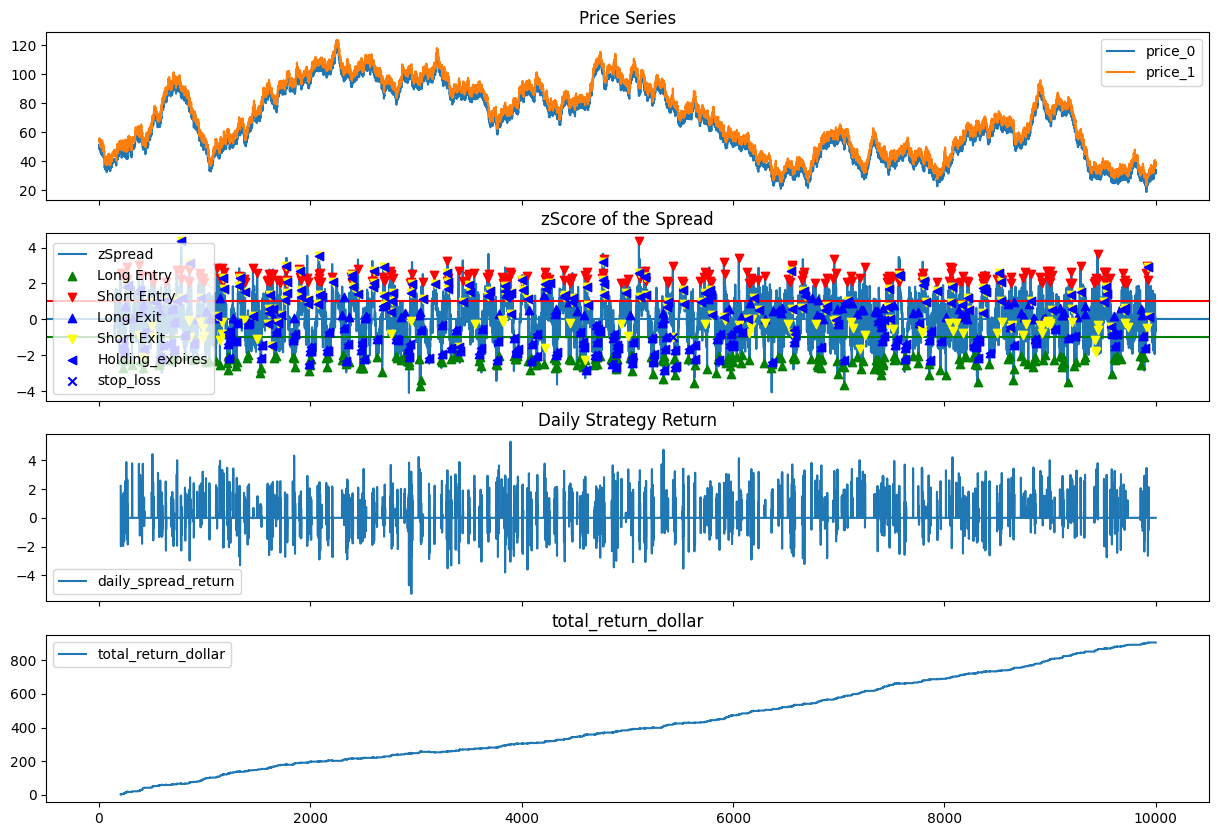

In [ ]:
plot_pair(df_result, 'price_0', 'price_1')

In [ ]:
# Here I'm experimenting different computation of Sharpe Ratio


df = pd.DataFrame()
# Dollar return Sharpe, this is the chosen method.
df["dollar_return"] = df_result["daily_strategy_return_dollar"]
print(sharp(df, "dollar_return"))

# Assume fixed capital
initial_capital = 1000
df["pct_return_fixed_cap"] = df["dollar_return"] / initial_capital
print(sharp(df, "pct_return_fixed_cap"))
# This will get the same sharpe as above regardless of initial_capital

# Assume I reinvest returns, which is what I have been doing in class
df["equity_1000"] = initial_capital + df_result["daily_strategy_return_dollar"].cumsum()
df["pct_return_reinvest_1000"] = df["equity_1000"].pct_change()
print(sharp(df, "pct_return_reinvest_1000"))

# This can get very different Sharpe depending on initial capital
initial_capital = 100
df["equity_10000"] = initial_capital + df_result["daily_strategy_return_dollar"].cumsum()
df["pct_return_reinvest_10000"] = df["equity_10000"].pct_change()
print(sharp(df, "pct_return_reinvest_10000"))


2.267515522807897
2.2675155228079524
2.3007765956489528
1.8892023977264494


# Real Data
First I plot pair-wise correlation for inspection. However, no meaningful insights can be drawn.

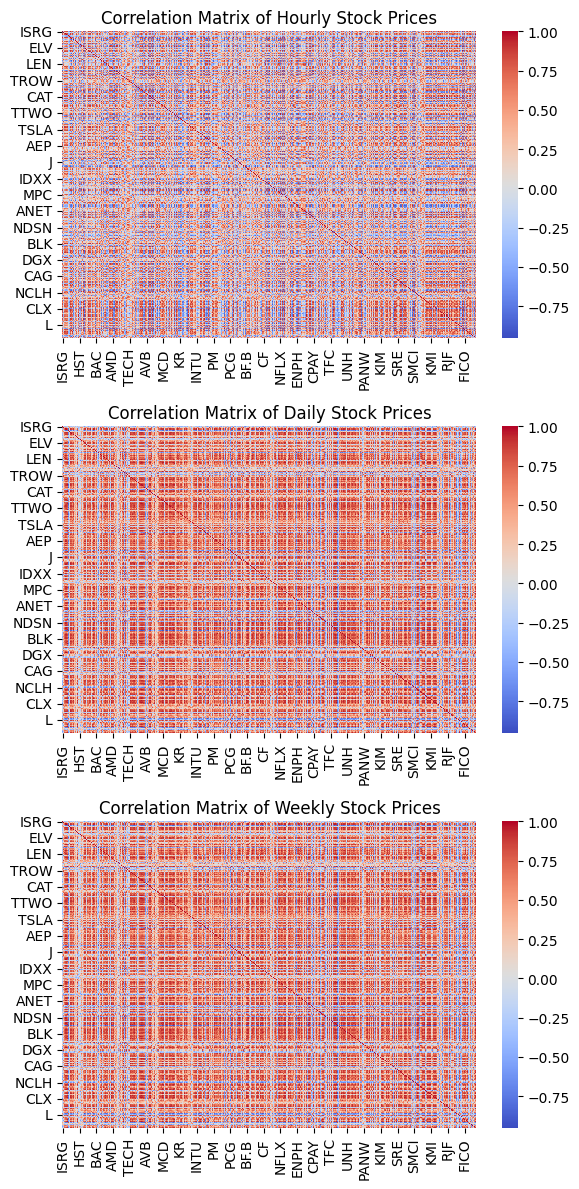

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(6, 12))

# Plotting correlation matrix heatmap for hourly data
sns.heatmap(df_hourly.corr(), annot=False, cmap='coolwarm', fmt=".2f", ax=axes[0])
axes[0].set_title('Correlation Matrix of Hourly Stock Prices')

# Plotting correlation matrix heatmap for daily data
sns.heatmap(df_daily.corr(), annot=False, cmap='coolwarm', fmt=".2f", ax=axes[1])
axes[1].set_title('Correlation Matrix of Daily Stock Prices')

# Plotting correlation matrix heatmap for weekly data
sns.heatmap(df_weekly.corr(), annot=False, cmap='coolwarm', fmt=".2f", ax=axes[2])
axes[2].set_title('Correlation Matrix of Weekly Stock Prices')

plt.tight_layout() # Adjust layout to prevent titles overlapping
plt.show()

In [ ]:
# Get top 200 correlated pairs for each df
def get_top_correlated_pairs(df, n=200):
    corr_matrix = df.corr().abs()
    # Keep upper triangular
    mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    corr_pairs = corr_matrix.where(mask)
    top = corr_pairs.stack().sort_values(ascending=False).head(n)
    return top

In [ ]:
weekly_top_200 = get_top_correlated_pairs(df_weekly)
daily_top_200 = get_top_correlated_pairs(df_daily)
hourly_top_200 = get_top_correlated_pairs(df_hourly)

In [ ]:
# Get our candidate symbols
weekly_symbols_200 = set(weekly_top_200.index.get_level_values(0)) | set(weekly_top_200.index.get_level_values(1))
daily_symbols_200 = set(daily_top_200.index.get_level_values(0)) | set(daily_top_200.index.get_level_values(1))
hourly_symbols_200 = set(hourly_top_200.index.get_level_values(0)) | set(hourly_top_200.index.get_level_values(1))
all_symbols = list(weekly_symbols_200 | daily_symbols_200 | hourly_symbols_200)
print(len(all_symbols))


195


In [ ]:
# Weekly Cointegration Test
start = datetime.datetime.now()
print(start)

coint_result_daily = gpu_coint_matrix(df_weekly[all_symbols])
coint_result_daily_matrix = build_pval_matrix(coint_result_daily)
# Save Result
coint_result_daily_matrix.to_csv('/content/drive/MyDrive/robo_project/weekly_coint_matrix.csv', index=True)
end = datetime.datetime.now()
print(end)
print(f'Weekly Time taken: {end-start}')

2025-05-13 19:15:24.039086
2025-05-13 19:23:05.496276
Weekly Time taken: 0:07:41.457190


In [ ]:
# Daily Cointegration Test
start = datetime.datetime.now()
print(start)

coint_result_daily = gpu_coint_matrix(df_daily[all_symbols])
coint_result_daily_matrix = build_pval_matrix(coint_result_daily)
# Save Result
coint_result_daily_matrix.to_csv('/content/drive/MyDrive/robo_project/daily_coint_matrix.csv', index=True)
end = datetime.datetime.now()
print(end)
print(f'Daily Time taken: {end-start}')

2025-05-13 19:23:05.502470
2025-05-13 19:47:56.220556
Daily Time taken: 0:24:50.718086


In [ ]:
# Hourly Cointegration Test
start = datetime.datetime.now()
print(start)

coint_result_hourly = gpu_coint_matrix(df_hourly[all_symbols])
coint_result_hourly_matrix = build_pval_matrix(coint_result_hourly)
# Save Result
coint_result_hourly_matrix.to_csv('/content/drive/MyDrive/robo_project/hourly_coint_matrix.csv', index=True)
end = datetime.datetime.now()
print(end)
print(f'Hourly Time taken: {end-start}')

2025-05-13 19:47:56.225559
2025-05-13 20:10:21.926511
Hourly Time taken: 0:22:25.700952


In [ ]:
# Load my coint matrix from files
coint_result_daily_matrix = pd.read_csv('/content/drive/MyDrive/robo_project/daily_coint_matrix.csv', index_col=0)
coint_result_hourly_matrix = pd.read_csv('/content/drive/MyDrive/robo_project/hourly_coint_matrix.csv', index_col=0)
coint_result_weekly_matrix = pd.read_csv('/content/drive/MyDrive/robo_project/weekly_coint_matrix.csv', index_col=0)

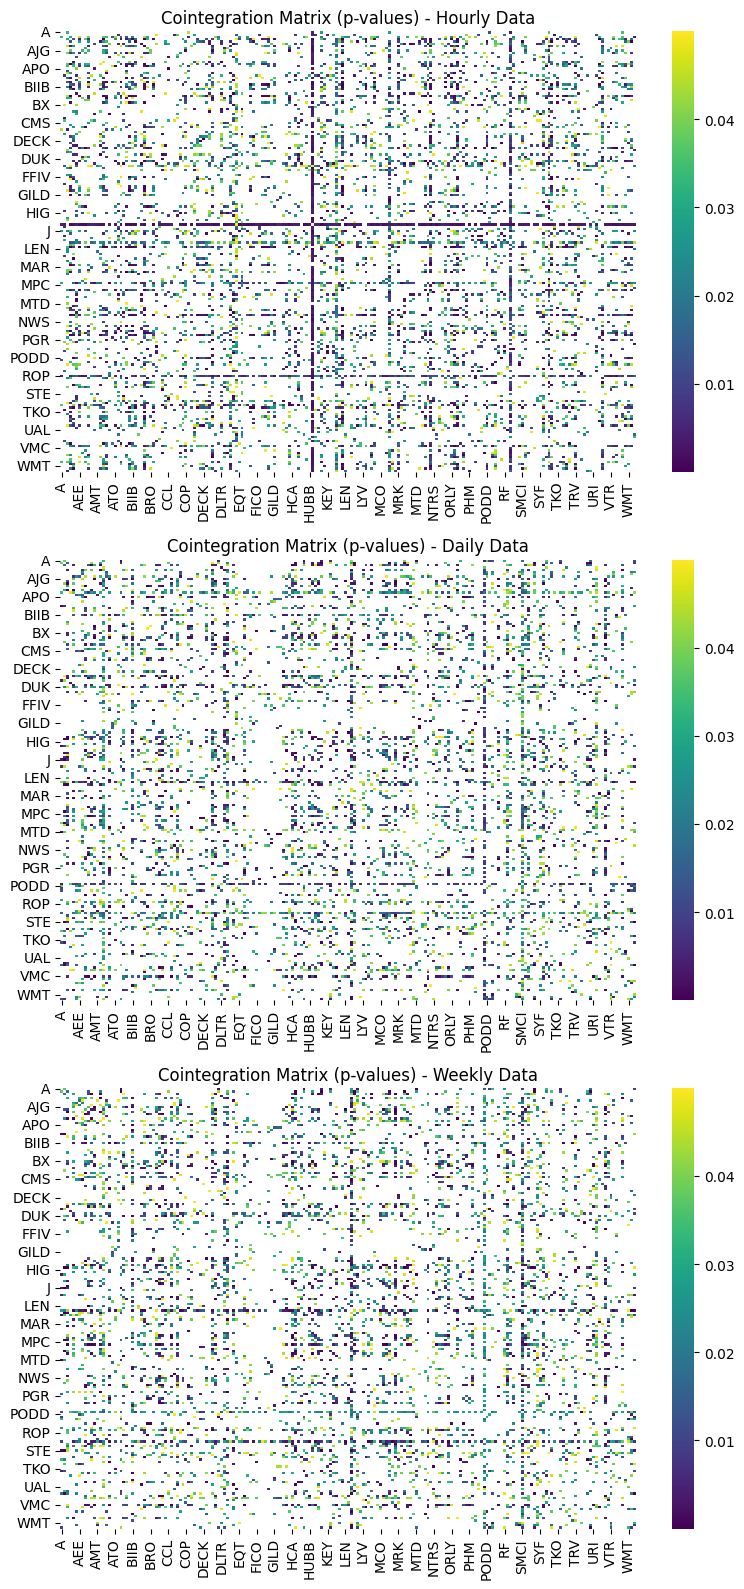

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(8, 16))

# Plotting cointegration matrix heatmap for hourly data
sns.heatmap(coint_result_hourly_matrix, annot=False, cmap='viridis', mask=(coint_result_hourly_matrix >= 0.05), ax=axes[0])
axes[0].set_title('Cointegration Matrix (p-values) - Hourly Data')

# Plotting cointegration matrix heatmap for daily data
sns.heatmap(coint_result_daily_matrix, annot=False, cmap='viridis', mask=(coint_result_daily_matrix >= 0.05), ax=axes[1])
axes[1].set_title('Cointegration Matrix (p-values) - Daily Data')

# Plotting cointegration matrix heatmap for weekly data
sns.heatmap(coint_result_weekly_matrix, annot=False, cmap='viridis', mask=(coint_result_weekly_matrix >= 0.05), ax=axes[2])
axes[2].set_title('Cointegration Matrix (p-values) - Weekly Data')

plt.tight_layout()
plt.show()

In [ ]:
# Sort pairs by p-value for each frequency (considering only upper triangular)
def sort_coint_pairs(coint_matrix):
    mask = np.triu(np.ones(coint_matrix.shape), k=1).astype(bool)
    coint_pairs = coint_matrix.where(mask)

    sorted_pairs = (
        coint_pairs.stack()
        .sort_values()
        .reset_index()
        .rename(columns={'level_0': 'symbol1', 'level_1': 'symbol2', 0: 'pvalue'})
    )
    return sorted_pairs

sorted_hourly_coint_pairs = sort_coint_pairs(coint_result_hourly_matrix)
sorted_daily_coint_pairs = sort_coint_pairs(coint_result_daily_matrix)
sorted_weekly_coint_pairs = sort_coint_pairs(coint_result_weekly_matrix)


print("Sorted Hourly Cointegrated Pairs by p-value:")
print(sorted_hourly_coint_pairs.head(10))

print("\nSorted Daily Cointegrated Pairs by p-value:")
print(sorted_daily_coint_pairs.head(10))

print("\nSorted Weekly Cointegrated Pairs by p-value:")
print(sorted_weekly_coint_pairs.head(10))

Sorted Hourly Cointegrated Pairs by p-value:
  symbol1 symbol2        pvalue
0       L    MCHP  7.800344e-07
1     DGX    WELL  2.964402e-06
2     DGX      PM  3.927048e-06
3    CBRE    NDAQ  4.169214e-06
4     ADM       V  6.357579e-06
5    PAYX     TDY  1.020383e-05
6      BR     MRK  1.285785e-05
7    FTNT      MA  1.818721e-05
8      BK     TDY  1.827880e-05
9     ADM       L  2.333183e-05

Sorted Daily Cointegrated Pairs by p-value:
  symbol1 symbol2    pvalue
0     DGX      MS  0.000003
1     STE     UNP  0.000004
2    AMAT    NXPI  0.000004
3    KLAC     VMC  0.000007
4      HD    SPGI  0.000007
5     APO     PGR  0.000007
6     ADI     AME  0.000007
7     AJG     PWR  0.000008
8     ETN     VMC  0.000011
9       J     STE  0.000016

Sorted Weekly Cointegrated Pairs by p-value:
  symbol1 symbol2        pvalue
0     DGX      MS  1.089195e-07
1     ACN       J  4.472079e-07
2    AMAT    MPWR  1.624309e-06
3     ACN      HD  1.919902e-06
4     ETN     URI  6.452069e-06
5     ADI   

In [ ]:
n = 500

# Get top n pairs for each frequency
top_n_hourly_pairs = sorted_hourly_coint_pairs.head(n)
top_n_daily_pairs = sorted_daily_coint_pairs.head(n)
top_n_weekly_pairs = sorted_weekly_coint_pairs.head(n)

# Extract pairs as sets of tuples with sorted elements for easy intersection
def get_sorted_pair_set(df):
    return set(tuple(sorted(pair)) for pair in zip(df['symbol1'], df['symbol2']))

hourly_pair_set = get_sorted_pair_set(top_n_hourly_pairs)
daily_pair_set = get_sorted_pair_set(top_n_daily_pairs)
weekly_pair_set = get_sorted_pair_set(top_n_weekly_pairs)

# Find the intersection of the top n pairs
union_pairs = list(hourly_pair_set.union(daily_pair_set, weekly_pair_set))

print(f"\Union of Top {n} Cointegrated Pairs across all frequencies:")
print(len(union_pairs))

Top 500 Hourly Cointegrated Pairs:
    symbol1 symbol2        pvalue
0         L    MCHP  7.800344e-07
1       DGX    WELL  2.964402e-06
2       DGX      PM  3.927048e-06
3      CBRE    NDAQ  4.169214e-06
4       ADM       V  6.357579e-06
..      ...     ...           ...
495     EXE    MPWR  3.147712e-03
496    INTU     MPC  3.148312e-03
497    MSCI     MTB  3.152745e-03
498    INTU     KMI  3.165826e-03
499       L    PODD  3.171649e-03

[500 rows x 3 columns]

Top 500 Daily Cointegrated Pairs:
    symbol1 symbol2    pvalue
0       DGX      MS  0.000003
1       STE     UNP  0.000004
2      AMAT    NXPI  0.000004
3      KLAC     VMC  0.000007
4        HD    SPGI  0.000007
..      ...     ...       ...
495     DTE     MCO  0.004746
496     AJG     ETN  0.004768
497     ADI      BX  0.004774
498     MLM     URI  0.004787
499     AMP     BRO  0.004801

[500 rows x 3 columns]

Top 500 Weekly Cointegrated Pairs:
    symbol1 symbol2        pvalue
0       DGX      MS  1.089195e-07
1       AC

Below are the codes for computing rolling betas. I splitted the list of pairs to different chunks and saved the files to avoid notebook crashing. We do not need to rerun this part every time.

In [ ]:
# import time
# import math

# intersection_pairs = sorted(intersection_pairs)

# chunk_size = math.ceil(len(intersection_pairs) / 10)
# print(chunk_size)

# # Weekly
# weekly_chunk_df = {}
# for i in range(10):
#   try:
#     start_time = time.time()
#     print(f"Starting chunk {i} at {start_time}")

#     start_idx = i * chunk_size
#     end_idx = min((i + 1) * chunk_size, len(intersection_pairs))
#     chunk = intersection_pairs[start_idx:end_idx]
#     print(chunk)
#     test = gpu_rolling_betas_pairs(df_weekly, chunk, 60)
#     weekly_chunk_df[i] = test
#     test.to_csv(f'/content/drive/MyDrive/robo_project/weekly_rolling_beta_chunk_{i}.csv', index=True)
#     end_time = time.time()
#     print(f"Time taken: {end_time - start_time} seconds\n")
#   except:
#     print(f"Chunk {i} failed")
#     continue

# # Daily
# daily_chunk_df = {}
# for i in range(10):
#   try:
#     start_time = time.time()
#     print(f"Starting chunk {i} at {start_time}")

#     start_idx = i * chunk_size
#     end_idx = min((i + 1) * chunk_size, len(intersection_pairs))
#     chunk = intersection_pairs[start_idx:end_idx]

#     test = gpu_rolling_betas_pairs(df_daily, chunk, 60)
#     daily_chunk_df[i] = test
#     test.to_csv(f'/content/drive/MyDrive/robo_project/daily_rolling_beta_chunk_{i}.csv', index=True)
#     end_time = time.time()
#     print(f"Time taken: {end_time - start_time} seconds")
#   except:
#     print(f"Chunk {i} failed")
#     continue

# # Hourly
# hourly_chunk_df = {}
# for i in range(10):
#   try:
#     start_time = time.time()
#     print(f"Starting chunk {i} at {start_time}")

#     start_idx = i * chunk_size
#     end_idx = min((i + 1) * chunk_size, len(intersection_pairs))
#     chunk = intersection_pairs[start_idx:end_idx]

#     test = gpu_rolling_betas_pairs(df_hourly, chunk, 60)
#     hourly_chunk_df[i] = test
#     test.to_csv(f'/content/drive/MyDrive/robo_project/hourly_rolling_beta_chunk_{i}.csv', index=True)
#     end_time = time.time()
#     print(f"Time taken: {end_time - start_time} seconds")
#   except:
#     print(f"Chunk {i} failed")
#     continue


In [ ]:
# Loading results
base_path = "/content/drive/MyDrive/robo_project"
patterns = {
    "hourly": [
        "hourly_rolling_beta_chunk_{}.csv",
        "hourly_rolling_beta_chunk_union_{}_full.csv"
    ],
    "daily": [
        "daily_rolling_beta_chunk_{}.csv",
        "daily_rolling_beta_chunk_union_{}_full.csv"
    ],
    "weekly": [
        "weekly_rolling_beta_chunk_{}.csv",
        "weekly_rolling_beta_chunk_union_{}.csv"
    ]
}

def load_concat_by_columns(freq):
    dfs = []
    for pattern in patterns[freq]:
        for i in range(9):
            file_path = f"{base_path}/{pattern.format(i)}"
            df = pd.read_csv(file_path, header=[0, 1])
            dfs.append(df)
    df_combined = pd.concat(dfs, axis=1)

    df_combined = df_combined.loc[:, ~df_combined.columns.duplicated()]

    return df_combined

df_beta_hourly = load_concat_by_columns("hourly")
df_beta_daily = load_concat_by_columns("daily")
df_beta_weekly = load_concat_by_columns("weekly")

In [ ]:
# Get all the pairs that I have data for
hourly_keys = set(map(tuple, df_beta_hourly.columns))
daily_keys = set(map(tuple, df_beta_daily.columns))
weekly_keys = set(map(tuple, df_beta_weekly.columns))

common_keys = hourly_keys & daily_keys & weekly_keys
common_keys = sorted(common_keys)

print(f"Number of common column keys: {len(common_keys)}")

Number of common column keys: 2333


In [ ]:
# Wrap out trading fucntion with copying, creating a new df for result
def run_pair_strategy(
    price_df,
    beta_df,
    pair,
    long_entry=-2,
    short_entry=2,
    long_exit=0,
    short_exit=0,
    enable_stop_loss=True,
    stop_loss_threshold=-5,
    holding_period_limit = 5
):
    x_symbol, y_symbol = pair

    df_synth = price_df[[x_symbol, y_symbol]].copy()
    beta_series = beta_df[(x_symbol, y_symbol)]
    df_synth[f'{x_symbol}_beta'] = beta_series.values


    spread, zScpread = compute_spread_and_zscore(df_synth, x_symbol, y_symbol)
    df_synth["spread"] = spread
    df_synth["zSpread"] = zScpread

    df_result = compute_pair(
        df_synth,
        x_symbol,
        y_symbol,
        long_entry=long_entry,
        short_entry=short_entry,
        long_exit=long_exit,
        short_exit=short_exit,
        enable_stop_loss=enable_stop_loss,
        stop_loss_threshold=stop_loss_threshold,
        holding_period_limit = holding_period_limit
    )

    return df_result

results_hourly = {}
results_daily = {}
results_weekly = {}

for pair in common_keys:
    try:
        results_hourly[pair] = run_pair_strategy(df_hourly, df_beta_hourly, pair, holding_period_limit=5, enable_stop_loss=True, stop_loss_threshold=-5)
        results_daily[pair] = run_pair_strategy(df_daily, df_beta_daily, pair, holding_period_limit=5, enable_stop_loss=True, stop_loss_threshold=-5)
        results_weekly[pair] = run_pair_strategy(df_weekly, df_beta_weekly, pair, holding_period_limit=5, enable_stop_loss=True, stop_loss_threshold=-5)
    except Exception as e:
        print(f"Failed on pair {pair}: {e}")


Failed on pair ('Unnamed: 0_level_0', 'Unnamed: 0_level_1'): "None of [Index(['Unnamed: 0_level_0', 'Unnamed: 0_level_1'], dtype='object')] are in the [columns]"


In [ ]:
# Computes results

def max_drawdown(df, col="total_return_dollar"):
    equity_curve = df[col]
    peak = equity_curve.cummax()
    drawdown = equity_curve - peak
    return drawdown.min()  # Most negative value

# Compute raw correlation matrices
corr_matrix_hourly = df_hourly.corr()
corr_matrix_daily = df_daily.corr()
corr_matrix_weekly = df_weekly.corr()

combined_results = {
    "hourly": {},
    "daily": {},
    "weekly": {}
}

for freq, results_dict, coint_matrix, corr_matrix in [
    ("hourly", results_hourly, coint_result_hourly_matrix, corr_matrix_hourly),
    ("daily", results_daily, coint_result_daily_matrix, corr_matrix_daily),
    ("weekly", results_weekly, coint_result_weekly_matrix, corr_matrix_weekly)
]:
    for pair in common_keys:
        try:
            s1, s2 = pair
            df = results_dict[pair]
            # print(sharp(df, "daily_strategy_return_dollar"))
            combined_results[freq][pair] = {
                "symbol_1": s1,
                "symbol_2": s2,
                "sharpe": sharp(df, "daily_strategy_return_dollar"),
                "total_return": df["total_return_dollar"].iloc[-1],
                "max_drawdown": max_drawdown(df),
                "coint_pval": coint_matrix.loc[s1, s2],
                "correlation": corr_matrix.loc[s1, s2],
                "std_dev": df["daily_strategy_return_dollar"].std()
            }
        except Exception as e:
            pass

df_hourly_results = pd.DataFrame.from_dict(combined_results["hourly"], orient="index")
df_daily_results = pd.DataFrame.from_dict(combined_results["daily"], orient="index")
df_weekly_results = pd.DataFrame.from_dict(combined_results["weekly"], orient="index")

            mean       std       min       max
Hourly -0.027415  0.342135 -1.048429  1.052661
Daily  -0.088875  0.324638 -1.126268  0.916447
Weekly -0.065563  0.825734 -2.893928  2.900290


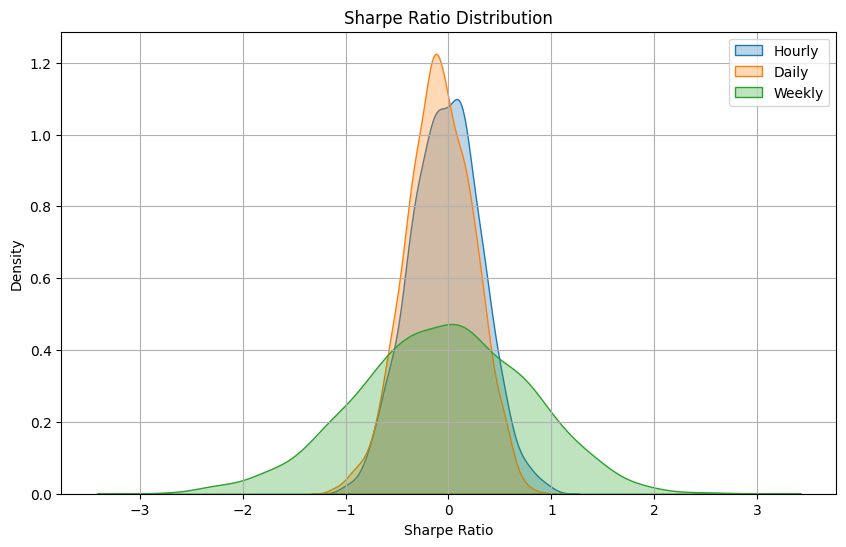

In [ ]:
# Summary table
sharpe_df = pd.DataFrame({
    "Hourly": df_hourly_results["sharpe"],
    "Daily": df_daily_results["sharpe"],
    "Weekly": df_weekly_results["sharpe"]
})

print(sharpe_df.describe().T[["mean", "std", "min", "max"]])

# KDE plot
plt.figure(figsize=(10, 6))

sns.kdeplot(df_hourly_results["sharpe"].dropna(), label="Hourly", fill=True, alpha=0.3)
sns.kdeplot(df_daily_results["sharpe"].dropna(), label="Daily", fill=True, alpha=0.3)
sns.kdeplot(df_weekly_results["sharpe"].dropna(), label="Weekly", fill=True, alpha=0.3)

plt.title("Sharpe Ratio Distribution")
plt.xlabel("Sharpe Ratio")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


All three strategies have slightly negative mean Sharpe ratios, suggesting that on average, the returns do not sufficiently justify for risk. Hourly trading has the least negative average Sharpe and daily has the worst.

Weekly trading shows much higher standard deviation. This implies Weekly contains outlier pairs that worked really well or very poorly. This could also attribute to low sample size.



             mean         std          min          max
Hourly   2.552173  164.034039 -1557.474994  3109.514056
Daily  -14.921220  268.885448 -5540.454017  3464.847311
Weekly -17.295737  203.955421 -2753.119278  2675.157571


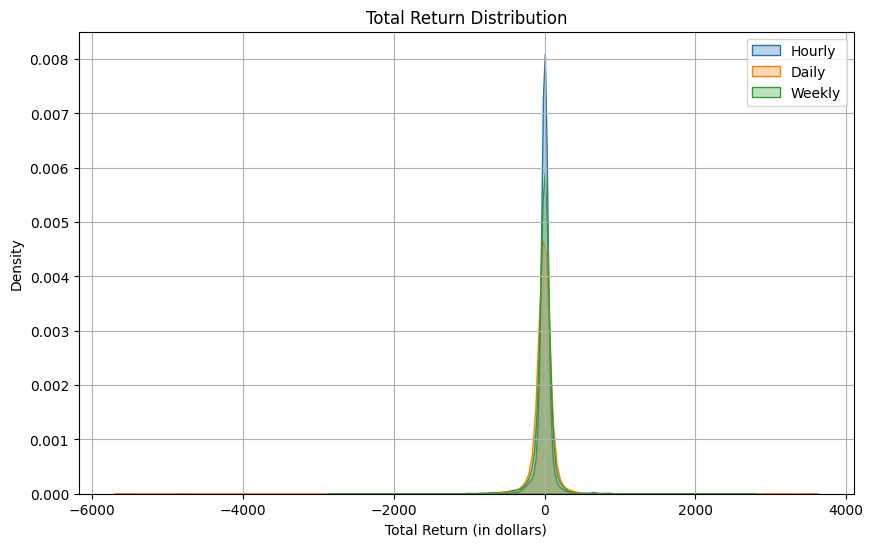

In [ ]:
# Summary table
return_df = pd.DataFrame({
    "Hourly": df_hourly_results["total_return"],
    "Daily": df_daily_results["total_return"],
    "Weekly": df_weekly_results["total_return"]
})

print(return_df.describe().T[["mean", "std", "min", "max"]])

# KDE plot
plt.figure(figsize=(10, 6))

sns.kdeplot(df_hourly_results["total_return"].dropna(), label="Hourly", fill=True, alpha=0.3)
sns.kdeplot(df_daily_results["total_return"].dropna(), label="Daily", fill=True, alpha=0.3)
sns.kdeplot(df_weekly_results["total_return"].dropna(), label="Weekly", fill=True, alpha=0.3)

plt.title("Total Return (Equity) Distribution")
plt.xlabel("Total Return (in dollars)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


The total return, which is the equivalent of equity, shows that only Hourly has a positive average. This indicates slower trading frequencies did not translate to higher return. In addition, the hourly strategy has the lowest standard deviation and the best negative tail risk (min). From the Total return, we can consider hourly less risky.

Daily return has the highest standard deviation and the worst negative tail risk.

            mean       std       min         max
Hourly  1.340781  2.607224  0.039393   39.175030
Daily   2.233323  4.730349  0.084971  100.813632
Weekly  5.203316  9.676243  0.167370  138.453946


<ipython-input-164-535841a1b16b>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


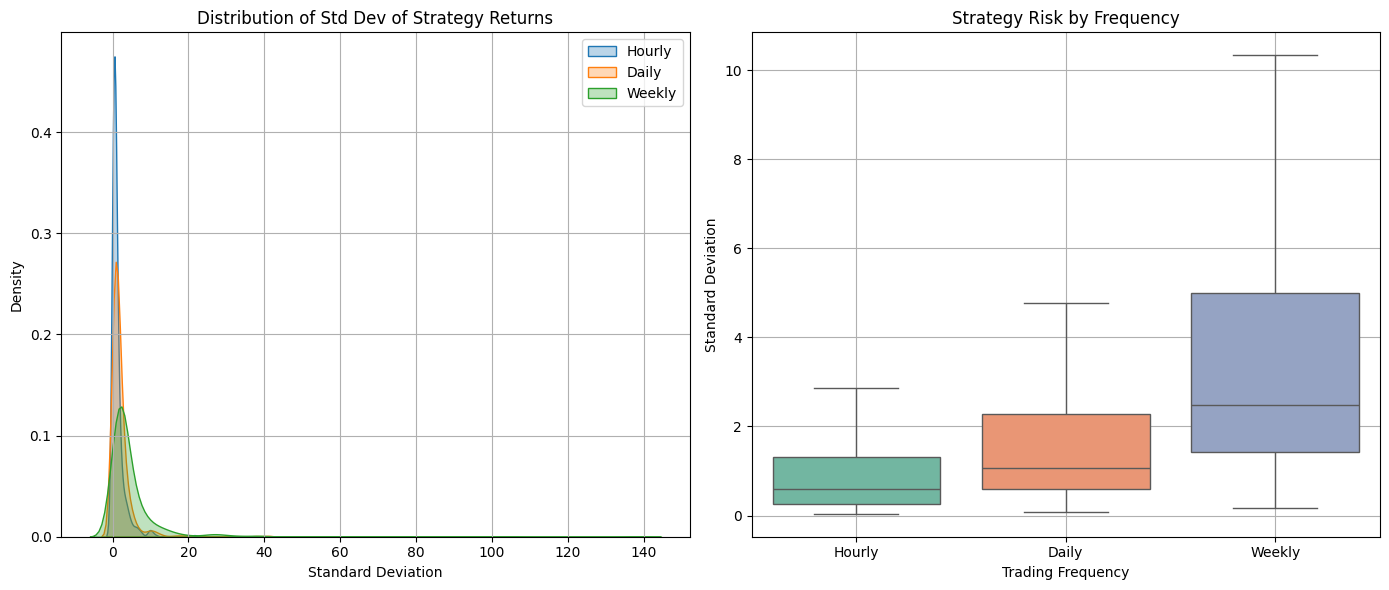

In [ ]:
risk_df = pd.DataFrame({
    "Hourly": df_hourly_results["std_dev"],
    "Daily": df_daily_results["std_dev"],
    "Weekly": df_weekly_results["std_dev"]
})

print(risk_df.describe().T[["mean", "std", "min", "max"]])

risk_melted = risk_df.melt(var_name="Frequency", value_name="StdDev")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Distribution
sns.kdeplot(df_hourly_results["std_dev"].dropna(), label="Hourly", fill=True, alpha=0.3, ax=axes[0])
sns.kdeplot(df_daily_results["std_dev"].dropna(), label="Daily", fill=True, alpha=0.3, ax=axes[0])
sns.kdeplot(df_weekly_results["std_dev"].dropna(), label="Weekly", fill=True, alpha=0.3, ax=axes[0])

axes[0].set_title("Distribution of Std Dev of Strategy Returns")
axes[0].set_xlabel("Standard Deviation")
axes[0].set_ylabel("Density")
axes[0].legend()
axes[0].grid(True)

# Box Plot
sns.boxplot(
    x="Frequency",
    y="StdDev",
    data=risk_melted,
    palette="Set2",
    showfliers=False,
    ax=axes[1]
)

axes[1].set_title("Strategy Risk by Frequency")
axes[1].set_xlabel("Trading Frequency")
axes[1].set_ylabel("Standard Deviation")
axes[1].grid(True)

plt.tight_layout()
plt.show()


This shows the distribution of risk (standard deviation) across three frequencies. Hourly strategies appear to be the least risky on all metrics. Hourly has the lowest average risk, lowest standard deviation of risk, and the lowest tails.

In addition, we observe an upward trend of risk as we decrease the trading frequencies. Frequent strategies preserve better control.

              mean         std          min       max
Hourly  -63.685920  119.283116 -2138.654536 -1.057345
Daily  -124.172020  272.397473 -6661.562169 -4.055758
Weekly -110.427792  243.911447 -4009.862158 -1.957727


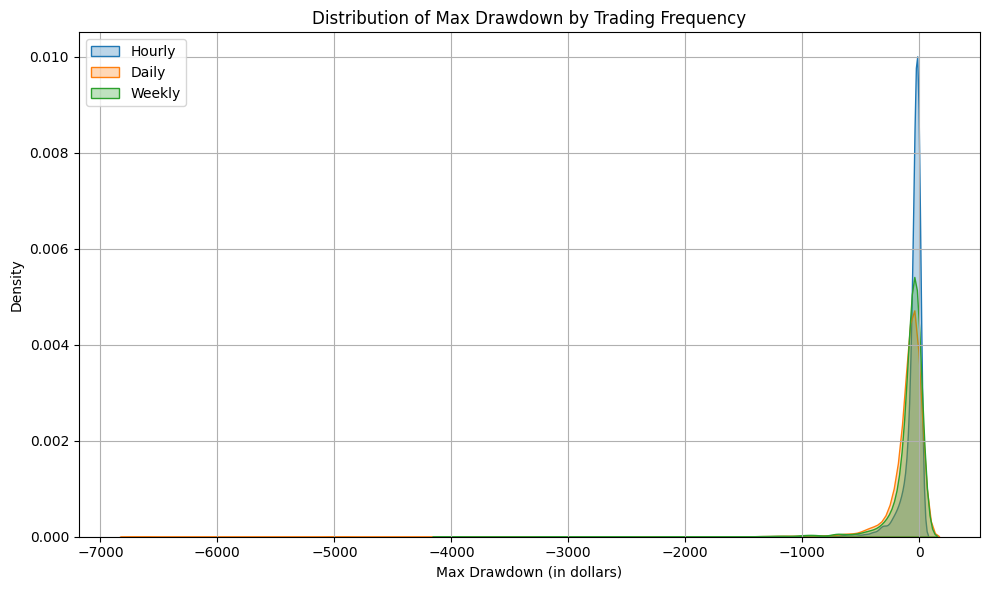

In [ ]:
drawdown_df = pd.DataFrame({
    "Hourly": df_hourly_results["max_drawdown"],
    "Daily": df_daily_results["max_drawdown"],
    "Weekly": df_weekly_results["max_drawdown"]
})

print(drawdown_df.describe().T[["mean", "std", "min", "max"]])

plt.figure(figsize=(10, 6))

sns.kdeplot(drawdown_df["Hourly"].dropna(), label="Hourly", fill=True, alpha=0.3)
sns.kdeplot(drawdown_df["Daily"].dropna(), label="Daily", fill=True, alpha=0.3)
sns.kdeplot(drawdown_df["Weekly"].dropna(), label="Weekly", fill=True, alpha=0.3)

plt.title("Distribution of Max Drawdown by Trading Frequency")
plt.xlabel("Max Drawdown (in dollars)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Hourly strategy shows the best (least negative) Max Drawdown with the smallest standard deviation and tightest tail. This is another indication that hourly strategy performs with less risk.

/usr/local/lib/python3.11/dist-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/usr/local/lib/python3.11/dist-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/usr/local/lib/python3.11/dist-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


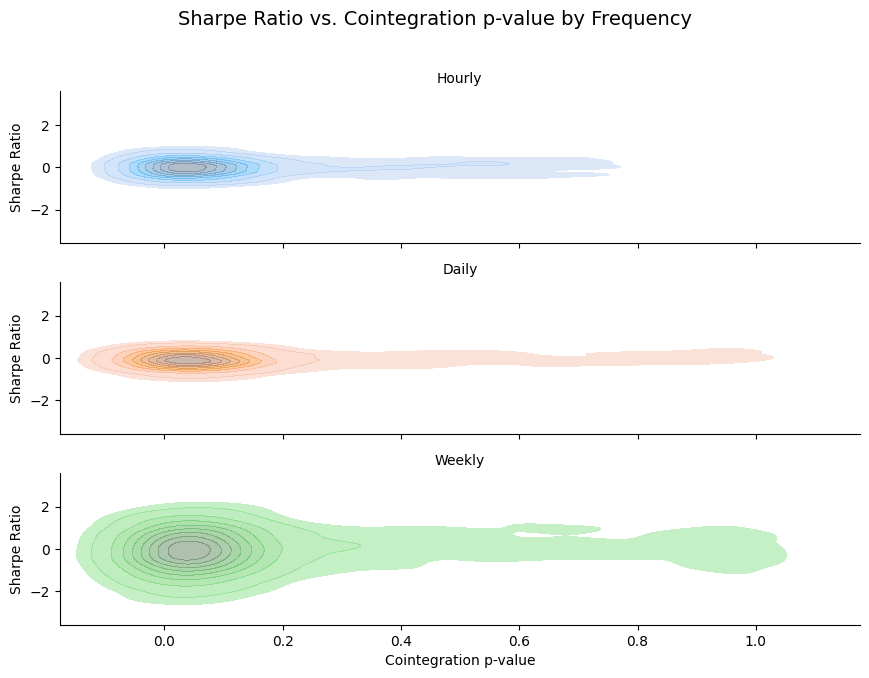

In [ ]:
# Ridge Plot
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_hourly_results["Frequency"] = "Hourly"
df_daily_results["Frequency"] = "Daily"
df_weekly_results["Frequency"] = "Weekly"

df_all = pd.concat([
    df_hourly_results[["coint_pval", "sharpe", "Frequency"]],
    df_daily_results[["coint_pval", "sharpe", "Frequency"]],
    df_weekly_results[["coint_pval", "sharpe", "Frequency"]],
])

df_all = df_all.dropna()

g = sns.FacetGrid(
    df_all,
    row="Frequency",
    hue="Frequency",
    aspect=4,
    height=2.2,
    sharex=True,
    sharey=True
)

g.map(
    sns.kdeplot,
    "coint_pval",
    "sharpe",
    fill=True,
    alpha=0.4,
    linewidth=1.5
)

g.set_titles("{row_name}")
g.set_axis_labels("Cointegration p-value", "Sharpe Ratio")
g.fig.suptitle("Sharpe Ratio vs. Cointegration p-value by Frequency", fontsize=14, y=1.02)
g.tight_layout()
plt.show()


This Ridge graph displays the distribution of Sharpe v.s. p-value of the cointegration test. We observe lower p-value (more co-integrated) leads to more wider Sharpe range. This could be because we selected the symbols by combining the union symbols and intersecting symbols.

We also observe that hourly strategy tightest distribution of Sharpe.

## Summary
This study examined how trading frequency impacts pairs trading performance in the U.S. equity market. Using a classic strategy with a rolling hedge ratio and z-score thresholds, we backtested 2,333 SP500 pairs across hourly, daily, and weekly frequencies under consistent parameters.

Key findings include:

- Risk-Adjusted Performance: All strategies showed slightly negative mean Sharpe ratios, with hourly trading performing best and daily worst.

- Risk Profile: Weekly strategies exhibited the highest risk and variability, while hourly trades were the most stable, showing the lowest average standard deviation and tightest distribution.

- Total Return (Equity): Only hourly trading achieved a positive average return, with the lowest return volatility and best downside protection.

- Max Drawdown: Hourly strategies had the least severe and most consistent drawdowns, reinforcing their lower risk.

- Sharpe vs. Cointegration: Stronger cointegration (lower p-values) was associated with a wider spread of Sharpe ratios, especially in hourly trading.

Overall, the results suggest that trading frequency has a significant impact on the risk characteristics of pairs trading. More frequent strategies (e.g., hourly) offer better consistency, tighter risk control, and more favorable performance across nearly all risk-adjusted metrics.

In [ ]:
# Save results of first 50 pairs

base_path = "/content/drive/MyDrive/robo_project/results"
for freq in ["hourly", "daily", "weekly"]:
    os.makedirs(os.path.join(base_path, freq), exist_ok=True)

# Save each result as CSV
for pair in common_keys[:50]:
    s1, s2 = pair
    filename = f"{s1}_{s2}.csv"

    # Hourly
    results_hourly[pair].to_csv(os.path.join(base_path, "hourly", filename), index=True)

    # Daily
    results_daily[pair].to_csv(os.path.join(base_path, "daily", filename), index=True)

    # Weekly
    results_weekly[pair].to_csv(os.path.join(base_path, "weekly", filename), index=True)
